In [1]:
import pandas as pd
import os
import re
import sys
import sklearn
import glob
from sklearn.covariance import EmpiricalCovariance, MinCovDet
import matplotlib.lines as mlines
from scipy import stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Load CSV 
all_files = glob.glob(os.path.join("../monthly_data", "*.csv"))

# Read each file and store in a list
df_list = [pd.read_csv(f) for f in all_files]

# Combine all DataFrames into a single one
bms_df = pd.concat(df_list, ignore_index=True)

In [3]:
final_cols = {
    'Timestamp': ['Timestamp'],
    'FCU': ['FCU-1 Cooling Load_kW', 'FCU-2 Cooling Load_kW', 'FCU-3 Cooling Load_kW', 'FCU-4 Cooling Load_kW','FCU-5 Cooling Load_kW'],
    'PFCU': ['PFCU-1 Cooling Load_kW','PFCU-2 Cooling Load_kW'],
    'Outdoor': ['Outdoor Temperature', 'Outdoor Humidity', 'Wind Speed', 'Wind Direction', 'Solar Radiation'],
    'Indoor_temp': ['Zone 1 Temperature', 'Zone 2 Temperature','Zone 3 Temperature', 'Zone 4 Temperature', 'Zone 5 Temperature'],
    'Occupancy': ['Zone 1  CO2 - S1','Zone 2 CO2','Zone 3  CO2', 'Zone 4 CO2','Zone 5 CO2 - S1'],
    'Window': ['Z7 Windows Open Close Status', 'Z6 Windows Open Close Status',
               'Z5 Windows Open Close Status', 'Z1 Windows Open Close Status',
               'Z2 Windows Open Close Status', 'Z3 Windows Open Close Status'],
    'Fan': ['Zone 1 Fan-1 Control', 'Zone 2G1 Fan-2 Control', 'Zone 3 Fan-1 Control', 'Zone 4 Fan-1 Control', 'Zone 5 Fan-1 Control']
}

# 1. FCU

In [4]:
bms_df[final_cols['FCU']].describe()

,FCU-1 Cooling Load_kW,FCU-2 Cooling Load_kW,FCU-3 Cooling Load_kW,FCU-4 Cooling Load_kW,FCU-5 Cooling Load_kW
count,722678.000000,754499.000000,754505.000000,754498.000000,754494.000000
mean,0.871582,1.482458,1.379061,0.984359,0.998804
std,2.163421,3.956562,2.613080,2.132071,2.323147
min,-27.953964,-13.892293,-8.238927,-6.281804,-10.563928
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.020178,0.000000,0.000000
75%,0.000000,1.618137,1.138666,1.036734,1.292825
max,51.435112,70.275043,45.186569,57.262474,62.988258


# 2. PFCU

In [5]:
bms_df[final_cols['PFCU']].describe()

,PFCU-1 Cooling Load_kW,PFCU-2 Cooling Load_kW
count,754505.000000,754492.000000
mean,3.301092,2.924026
std,3.784298,3.607925
min,-14.834090,-22.191670
25%,0.000000,0.000000
50%,1.934017,1.316061
75%,5.949211,5.004215
max,40.672321,53.873611


# 3. Outdoor

In [6]:
bms_df[final_cols['Outdoor']].describe()

,Outdoor Temperature,Outdoor Humidity,Wind Speed,Wind Direction,Solar Radiation
count,295415.000000,622323.000000,746208.000000,744569.000000,367187.000000
mean,291.731565,788.012903,212.207398,1759.529869,328.084228
std,22.052303,108.763927,173.997157,937.899494,289.949577
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,277.000000,712.000000,76.000000,1133.000000,92.000000
50%,294.000000,803.000000,162.000000,1786.000000,243.000000
75%,309.000000,867.000000,307.000000,2262.000000,494.000000
max,352.000000,1000.000000,1514.000000,3599.000000,1459.000000


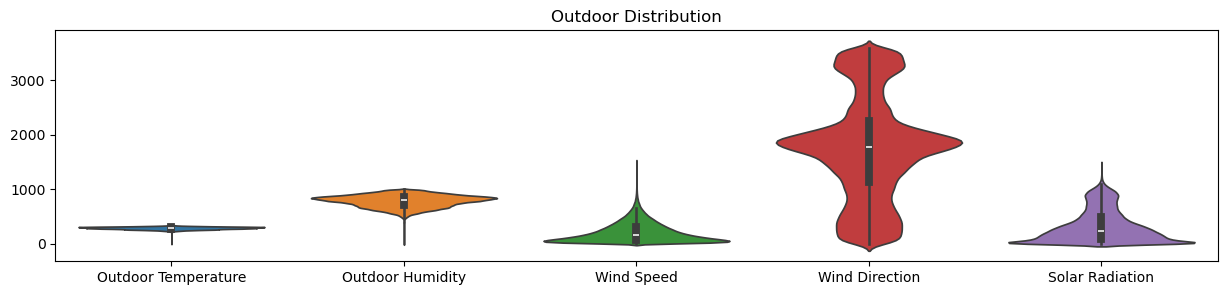

In [ ]:
plt.figure(figsize=(15,3))
sns.violinplot(data=bms_df[final_cols['Outdoor']])
plt.title("Outdoor Distribution")
plt.show()

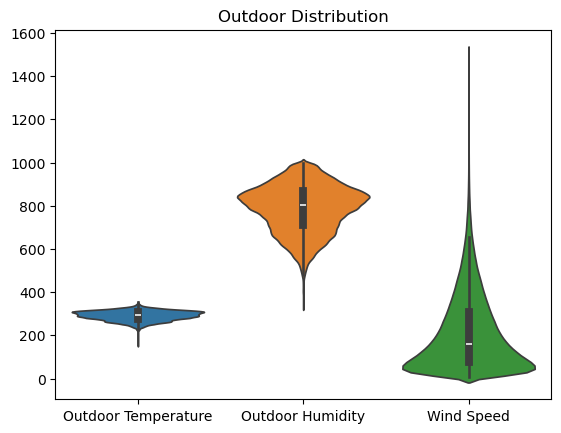

In [15]:
temp_df = bms_df[["Outdoor Temperature", "Outdoor Humidity", "Wind Speed"]].replace(0, np.nan)
sns.violinplot(data=temp_df)
plt.title("Outdoor Distribution")
plt.show()

In [ ]:
# Specify columns where 0 values should be replaced with NaN
cols_to_replace = ["Outdoor Temperature", "Outdoor Humidity", "Wind Speed"]

# Replace 0 with NaN only in the selected columns (update original DataFrame)
bms_df[cols_to_replace] = bms_df[cols_to_replace].replace(0, np.nan)

In [ ]:
# Define the column name for wind direction
col = "Wind Direction"   

# 1) Normalize values to a valid range: adjust negative or >360° values to within 0–360°
wd_deg = bms_df[col] % 3600

# 2) Convert degrees to radians
wd_rad = np.deg2rad(wd_deg)

# 3) Apply cyclic encoding to ensure 0° ≡ 360°
bms_df["WindDir_sin"] = np.sin(wd_rad)
bms_df["WindDir_cos"] = np.cos(wd_rad)


# 4) Remove the original wind direction column
bms_df.drop(columns=[col], inplace=True)

# 5) Update final_cols to replace 'Wind Direction' with 'WindDir_sin' and 'WindDir_cos'
final_cols['Outdoor'] = [c for c in final_cols['Outdoor'] if c != 'Wind Direction'] + ['WindDir_sin', 'WindDir_cos']

# 4. Indoor_temp

In [11]:
bms_df[final_cols['Indoor_temp']].describe()

,Zone 1 Temperature,Zone 2 Temperature,Zone 3 Temperature,Zone 4 Temperature,Zone 5 Temperature
count,754313.000000,754331.000000,754311.000000,754313.000000,754312.000000
mean,29.515028,29.107233,29.099957,28.982891,28.540414
std,1.212567,1.314126,1.117286,1.321312,1.232456
min,24.825001,25.000000,13.062499,12.443749,24.781250
25%,28.656250,28.150002,28.312502,28.118750,27.637499
50%,29.593750,29.275000,29.125000,29.118750,28.450001
75%,30.368752,30.137501,29.937500,30.012501,29.562500
max,32.812500,32.343750,32.250000,32.843750,32.118752


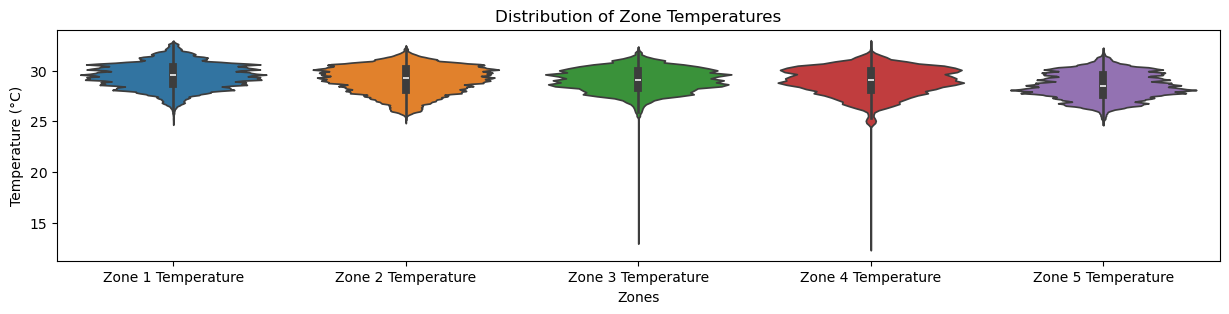

In [ ]:
# Zone Temperature
plt.figure(figsize=(15,3))
sns.violinplot(data=bms_df[final_cols['Indoor_temp']])
plt.title("Distribution of Zone Temperatures")
plt.ylabel("Temperature (°C)")
plt.xlabel("Zones")
plt.show()

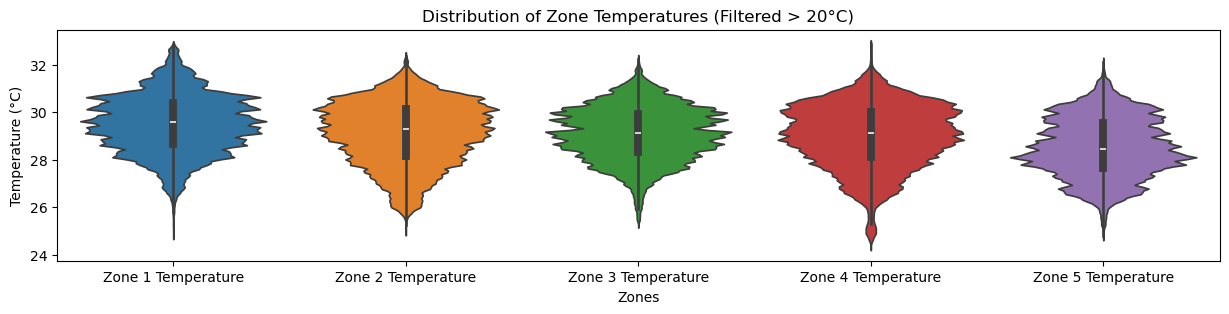

In [13]:
temp_df = bms_df[final_cols['Indoor_temp']].mask(bms_df[final_cols['Indoor_temp']] <= 20)
plt.figure(figsize=(15,3))
sns.violinplot(data=temp_df)
plt.title("Distribution of Zone Temperatures (Filtered > 20°C)")
plt.ylabel("Temperature (°C)")
plt.xlabel("Zones")
plt.show()

In [ ]:
# update indoor temp column

bms_df[final_cols['Indoor_temp']] = bms_df[final_cols['Indoor_temp']].mask(
    bms_df[final_cols['Indoor_temp']] < 20, 
    np.nan
)

# 5. Occupancy

In [20]:
bms_df[final_cols['Occupancy']].describe()

,Zone 1 CO2 - S1,Zone 2 CO2,Zone 3 CO2,Zone 4 CO2,Zone 5 CO2 - S1
count,754340.000000,754339.000000,754326.000000,754326.000000,754328.000000
mean,442.596427,458.776663,447.696879,450.840625,451.910172
std,35.339649,50.858697,48.603900,48.148069,50.868573
min,353.500000,360.673070,286.875000,278.375031,348.333323
25%,421.250000,424.312508,415.416656,419.833323,418.750000
50%,433.500000,441.416687,429.416677,432.500000,432.250000
75%,453.000000,476.750023,464.500015,467.000015,468.416667
max,769.874969,792.249969,798.545449,765.166687,853.749969


# 6. Window

In [21]:
bms_df[final_cols['Window']].describe()

,Z7 Windows Open Close Status,Z6 Windows Open Close Status,Z5 Windows Open Close Status,Z1 Windows Open Close Status,Z2 Windows Open Close Status,Z3 Windows Open Close Status
count,168708.000000,168567.000000,168476.000000,624831.000000,624800.000000,624517.000000
mean,0.115531,0.113919,0.115969,0.067623,0.059942,0.068977
std,0.319663,0.317714,0.320189,0.251098,0.237380,0.253414
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# 7. Fan

In [22]:
bms_df[final_cols['Fan']].describe()

,Zone 1 Fan-1 Control,Zone 2G1 Fan-2 Control,Zone 3 Fan-1 Control,Zone 4 Fan-1 Control,Zone 5 Fan-1 Control
count,754115.000000,754341.000000,754328.000000,754099.000000,754100.000000
mean,20.817685,21.102978,21.776060,22.544873,27.783201
std,25.391121,25.235293,27.491839,22.775472,23.424201
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,19.500000,35.000000
75%,35.000000,35.000000,45.000000,35.000000,35.000000
max,90.000000,80.000000,90.000000,100.000000,91.000000


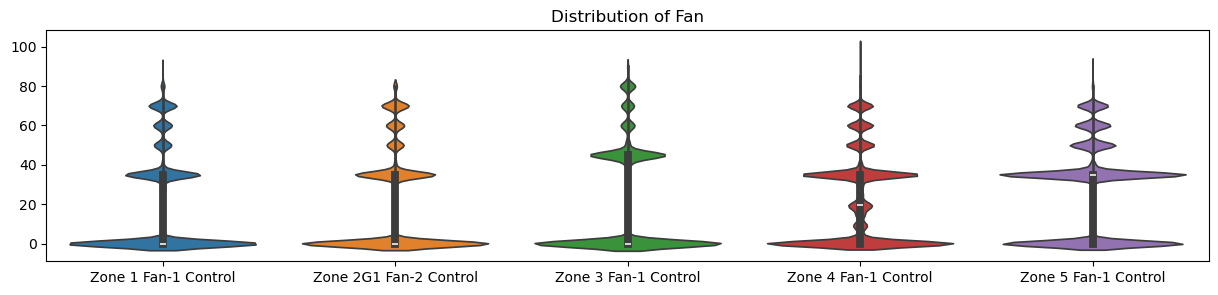

In [24]:
plt.figure(figsize=(15,3))
sns.violinplot(data=bms_df[final_cols['Fan']])
plt.title("Distribution of Fan")
plt.show()